<a href="https://colab.research.google.com/github/AeroPace/ME-592/blob/main/ME592_HW4_PointNet_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#in reference to https://keras.io/examples/vision/pointnet/
!pip install path.py
!pip install libhdf5-dev
!pip install h5py
!pip install trimesh

ERROR: Could not find a version that satisfies the requirement libhdf5-dev (from versions: none)
ERROR: No matching distribution found for libhdf5-dev
     |████████████████████████████████| 642 kB 30.0 MB/s 


In [ ]:
from path import Path
!wget modelnet.cs.princeton.edu/ModelNet40.zip
!unzip -q ModelNet40.zip

path = Path("ModelNet40")

--2022-04-17 18:27:16--  http://modelnet.cs.princeton.edu/ModelNet40.zip
Resolving modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)... 128.112.136.61
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.61|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2039180837 (1.9G) [application/zip]
Saving to: ‘ModelNet40.zip’

ModelNet40.zip      100%[===================>]   1.90G  13.1MB/s    in 2m 31s  

2022-04-17 18:29:47 (12.9 MB/s) - ‘ModelNet40.zip’ saved [2039180837/2039180837]



In [ ]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

data_dir = tf.keras.utils.get_file('ModelNet40.zip', 'http://modelnet.cs.princeton.edu/ModelNet40.zip', extract=True)
data_dir = os.path.join(os.path.dirname(data_dir), 'ModelNet40')

2039193600/2039180837 [==============================] - 150s 0us/step


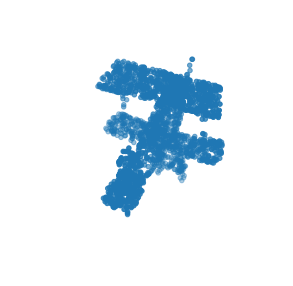

In [ ]:
mesh = trimesh.load(os.path.join(data_dir, 'airplane/train/airplane_0001.off'))
mesh.show()

pts = mesh.sample(2048)
f = plt.figure(figsize=(5,5))
ax = f.add_subplot(111, projection='3d')
ax.scatter(pts[:,0], pts[:,1], pts[:,2])
ax.set_axis_off()
plt.show()

In [ ]:
def parse_dataset(num_pts=2048):
  train_pts = []
  train_lab = []
  test_pts = []
  test_lab = []
  class_map = {}
  folders = glob.glob(os.path.join(data_dir, '[!README]*'))

  for i, folder in enumerate(folders):
    print('processing class: {}'.format(os.path.basename(folder)))
    class_map[i] = folder.split('/')[-1]
    train_files = glob.glob(os.path.join(folder, 'train/*'))
    test_files = glob.glob(os.path.join(folder, 'test/*'))

    for g in train_files:
      train_pts.append(trimesh.load(g).sample(num_pts))
      train_lab.append(i)

    for g in test_files:
      test_pts.append(trimesh.load(g).sample(num_pts))
      test_lab.append(i)
  return(np.array(train_pts), np.array(test_pts), np.array(train_lab), np.array(test_lab), class_map)

In [ ]:
NUM_PTS = 1024
NUM_CLASSES = 40
BATCH_SZE = 64

train_pts, test_pts, train_lab, test_lab, CLASS_MAP = parse_dataset(NUM_PTS)

processing class: toilet
processing class: tv_stand
processing class: cone
processing class: guitar
processing class: bathtub
processing class: glass_box
processing class: chair
processing class: mantel
processing class: person
processing class: laptop
processing class: cup
processing class: sink
processing class: sofa
processing class: tent
processing class: xbox
processing class: range_hood
processing class: stool
processing class: bench
processing class: desk
processing class: vase
processing class: car
processing class: plant
processing class: stairs
processing class: night_stand
processing class: bottle
processing class: bowl
processing class: radio
processing class: wardrobe
processing class: door
processing class: lamp
processing class: bed
processing class: monitor
processing class: flower_pot
processing class: airplane
processing class: keyboard
processing class: dresser
processing class: piano
processing class: table
processing class: curtain
processing class: bookshelf


In [ ]:
def augment(pts, lab):
  pts += tf.random.uniform(pts.shape, -0.001, 0.001, dtype=tf.float64) #jitter points
  pts = tf.random.shuffle(pts) #randomize pts
  return pts, lab

trainData = tf.data.Dataset.from_tensor_slices((train_pts, train_lab))
testData = tf.data.Dataset.from_tensor_slices((test_pts, test_lab))

trainData = trainData.shuffle(len(train_pts)).map(augment).batch(BATCH_SZE)
testData = testData.shuffle(len(test_pts)).map(augment).batch(BATCH_SZE)



In [ ]:
#Building CNN

def conv(x, filters):
  x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
  x = layers.BatchNormalization(momentum=0.9)(x)
  return layers.Activation('sigmoid')(x)

def dens(x, filters):
  x = layers.Dense(filters)(x)
  x = layers.BatchNormalization(momentum=0.0)(x)
  return layers.Activation('relu')(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
  def __init__(self, num_feat, reg=0.01):
      self.num_feat = num_feat
      self.reg = reg
      self.eye = tf.eye(num_feat)
  
  def __call__(self, x):
      x = tf.reshape(x, (-1, self.num_feat, self.num_feat))
      xt = tf.tensordot(x, x, axes=(2, 2))
      xt = tf.reshape(xt, (-1, self.num_feat, self.num_feat))
      return tf.reduce_sum(self.reg*tf.square(xt-self.eye))

In [ ]:
#define T-net layers
def tnet(inputs, num_feat):
  bias = keras.initializers.Constant(np.eye(num_feat).flatten())
  reg = OrthogonalRegularizer(num_feat)

  x = conv(inputs, 32)
  x = conv(x, 64)
  x = conv(x, 512)
  x = layers.GlobalAveragePooling1D()(x)
  x = dens(x, 256)
  x = dens(x, 128)
  x = layers.Dense(num_feat*num_feat, kernel_initializer='zeros', bias_initializer=bias, activity_regularizer=reg)(x)
  featT = layers.Reshape((num_feat, num_feat))(x)
  return layers.Dot(axes=(2,1))

In [ ]:
inputs = tf.keras.Input(shape=(NUM_PTS, 3)) # batch_size=BATCH_SZE, name='PointNet', dtype=None, sparse=None, tensor=True)

x = tnet(inputs, 3)
x = conv(inputs, 32)
x = conv(x, 32)
x = tnet(inputs, 32)
x = conv(inputs, 32)
x = conv(inputs, 64)
x = conv(inputs, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dens(x, 256)
x = layers.Dropout(0.9)(x)
x = dens(x, 128)
x = layers.Dropout(0.9)(x)

outputs = layers.Dense(NUM_CLASSES, activation="elu")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="PointNet")
model.summary()


Model: "PointNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1024, 3)]         0         
                                                                 
 conv1d_43 (Conv1D)          (None, 1024, 512)         2048      
                                                                 
 batch_normalization_65 (Bat  (None, 1024, 512)        2048      
 chNormalization)                                                
                                                                 
 activation_65 (Activation)  (None, 1024, 512)         0         
                                                                 
 global_max_pooling1d_3 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_33 (Dense)            (None, 256)               131

Epoch 1/50
154/154 [==============================] - 9s 48ms/step - loss: 9.5809 - sparse_categorical_accuracy: 0.0599 - val_loss: 10.1224 - val_sparse_categorical_accuracy: 0.0405
Epoch 2/50
154/154 [==============================] - 7s 45ms/step - loss: 9.4168 - sparse_categorical_accuracy: 0.0671 - val_loss: 9.9931 - val_sparse_categorical_accuracy: 0.0405
Epoch 3/50
154/154 [==============================] - 7s 45ms/step - loss: 9.4351 - sparse_categorical_accuracy: 0.0703 - val_loss: 10.5562 - val_sparse_categorical_accuracy: 0.0405
Epoch 4/50
154/154 [==============================] - 7s 45ms/step - loss: 9.1774 - sparse_categorical_accuracy: 0.0701 - val_loss: 10.7989 - val_sparse_categorical_accuracy: 0.0405
Epoch 5/50
154/154 [==============================] - 7s 46ms/step - loss: 9.2469 - sparse_categorical_accuracy: 0.0768 - val_loss: 10.4806 - val_sparse_categorical_accuracy: 0.0405
Epoch 6/50
154/154 [==============================] - 7s 46ms/step - loss: 9.0593 - sparse_

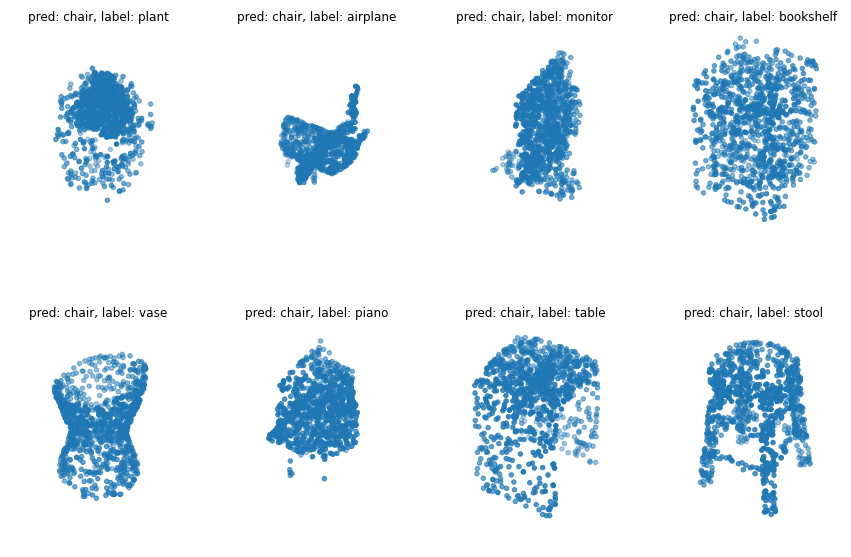

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adagrad(learning_rate=1e-02, initial_accumulator_value=0.1, epsilon=1e-03,), metrics=["sparse_categorical_accuracy"])
history = model.fit(trainData, epochs=50, batch_size=4, validation_data=testData)

data = testData.take(1)
pts, lab = list(data)[0]
pts = pts[:100, ...]
lab = lab[:100, ...]

pred = model.predict(pts)
pred = tf.math.argmax(pred, -1)
pts = pts.numpy()

fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(pts[i, :, 0], pts[i, :, 1], pts[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[pred[i].numpy()], CLASS_MAP[lab[i].numpy()]
        )
    )
    ax.set_axis_off()

plt.show()